<a href="https://colab.research.google.com/github/ilmaaliyaf/polemik-kebijakan/blob/master/PolemikKebijakan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk, re, pandas as pd
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Menyiapkan Kamus

In [ ]:
#kamus lengkapnya ada di https://github.com/ilmaaliyaf/polemik-kebijakan
#diambil dari https://github.com/masdevid/sentistrength_id/blob/master/sentistrength_id.py
'''menyiapkan kamus kata sentimental dan kata ungkapan'''
sentiment_word = pd.read_csv("https://raw.githubusercontent.com/ilmaaliyaf/polemik-kebijakan/master/sentiwords_id.txt",sep=':',engine="python",header=None)
senword = dict(zip(sentiment_word[0], sentiment_word[1]))
print(senword)
#idioms = pd.read_csv("https://raw.githubusercontent.com/ilmaaliyaf/polemik-kebijakan/master/idioms_id.txt",sep=':',engine="python",header=None)

'''menyiapkan kamus kata booster'''
booster_word = pd.read_csv("https://github.com/ilmaaliyaf/polemik-kebijakan/raw/master/boosterwords_id.txt",sep=':',engine="python",header=None)
booword = dict(zip(booster_word[0], booster_word[1]))
print(booword)


'''menyiapkan kamus kata negasi'''
negation_word = pd.read_csv("https://raw.githubusercontent.com/ilmaaliyaf/polemik-kebijakan/master/negatingword.txt",engine="python",header=None)
negword = dict(zip(negation_word[0],negation_word[0]))
print(negword)

#data kamus dibuat secara manual
'''menyiapkan kamus pengubahan kata tak baku ke kata baku'''
subtitute_word = pd.read_csv("https://raw.githubusercontent.com/ilmaaliyaf/polemik-kebijakan/master/subs.txt",sep='\t',engine="python")
subword = dict(zip(subtitute_word['asli'], subtitute_word['ganti']))
print(subword)

'''menyiapkan kamus emoticon'''
#data kamus diambil secara manual dari http://kt.ijs.si/data/Emoji_sentiment_ranking/
emoticon = pd.read_excel("https://github.com/ilmaaliyaf/polemik-kebijakan/blob/master/emoticon.xlsx?raw=true",sep='')
emot = dict(zip(emoticon['Char'],emoticon['Sentiment score']))
for key in emot:
    emot[key] = round(emot[key]*10,2) #mengubah rentang nilai sentiment dari [-1,1] ke [-10,10]
print(emot)

'''menyiapkan kamus stopword'''
stopword = pd.read_excel("https://github.com/ilmaaliyaf/polemik-kebijakan/blob/master/stopwords.xlsx?raw=true")
stopword1 = stopword['stopwords'].tolist()
print(stopword1)  

{'abadi': 5, 'absen': -3, 'abu-abu': -1, 'acuh': 4, 'adil': 5, 'aduh': -2, 'agresi': -5, 'aib': -5, 'ajaib': 3, 'ajar': 4, 'akal': 4, 'alasan': -2, 'alibi': -4, 'alien': -1, 'aman': 4, 'ambigu': -3, 'ambisi': -2, 'amoral': -5, 'anarki': -5, 'anarkis': -5, 'ancaman': -5, 'aneh': -2, 'anggun': 4, 'angkuh': -5, 'anjing': -4, 'anomali': -3, 'antagoni': -4, 'anti-sosial': -4, 'antipati': -5, 'apes': -4, 'api': -1, 'arogan': -5, 'asam': -1, 'asap': -2, 'asing': -4, 'asli': 4, 'asmara': 4, 'astaga': -5, 'asyik': 4, 'autentik': 4, 'aversi': -4, 'awas': -4, 'awur': -4, 'ayam': 1, 'ayu': 4, 'azab': -5, 'babu': -5, 'bacot': -5, 'badai': -4, 'badut': -2, 'bagus': 4, 'bahagia': 4, 'bahaya': -4, 'baik': 4, 'bail': -2, 'bajingan': -5, 'bakat': 3, 'banci': -4, 'bandel': -4, 'bandit': -4, 'bangga': 4, 'bangkrut': -5, 'banjir': -4, 'barbari': -5, 'basi': -4, 'batu': -1, 'bau': -4, 'baut': 1, 'bawaan': -1, 'bawah': -1, 'bayaran': -3, 'beban': -2, 'bego': -5, 'bekas': -4, 'bekicot': -4, 'belahan': -1, 'be

# Membersihkan Data

In [ ]:
'''mengimpor data'''
Data1 = pd.read_excel("https://github.com/ilmaaliyaf/polemik-kebijakan/blob/master/Data.xlsx?raw=true", sheet_name=0)
Data2 = pd.read_excel("https://github.com/ilmaaliyaf/polemik-kebijakan/blob/master/Data.xlsx?raw=true", sheet_name=1)
Data3 = pd.read_excel("https://github.com/ilmaaliyaf/polemik-kebijakan/blob/master/Data.xlsx?raw=true", sheet_name=2)
#sheet_name:0 = data 1
#sheet_name:1 = data 2
#sheet_name:2 = data 3
#columns available: Screen Name | Tweet Text | Retweets | Favorites | Followers | Date | Verfied

In [ ]:
'''fungsi untuk membuat semua tulisan menjadi lowercase'''
def lowerCase(df):
    df["Tweet Text"] = df["Tweet Text"].str.lower()
    return df

'''fungsi untuk menyaring data dari kata-kata tertentu'''
def dataFilter(df,word_list):
    df = lowerCase(df)
    df = df[~df["Tweet Text"].str.contains('|'.join(word_list), na=False)]
    return df

'''fungsi untuk menghapus karakter tak diperlukan dari row Tweet of Text'''
def dataCleaner(df):
    for i in range(0,len(df)):
        #dataTweet[i] = re.sub('(?<=@)[^\s]+',' ',str(dataTweet[i]))
        #dataTweet[i] = re.sub('RT ',' ',str(dataTweet[i]))
        df1 = df["Tweet Text"]
        df1[i] = re.sub('[,.<>\\\/\'\"\}\{\]\[\)\(;:?!¥£€$²™�©±˜~`+‘’”‡»«]',
                              ' ',str(df1[i]))
    return df

'''fungsi untuk tokenisasi data menjadi list of list'''
def tokenize(df):
    tweets_tokenized = []
    for i in df:
        tweets_tokenized.append(nltk.word_tokenize(i))
    return tweets_tokenized

'''fungsi untuk mengubah kata-kata tak baku pada tweets menjadi kata baku'''
def wordSubs(dataTweet):
    for i in range(0,len(dataTweet)):
        for j in range(0,len(dataTweet[i])):
            if dataTweet[i][j] in subword:
                dataTweet[i][j] = subword[dataTweet[i][j]]
        return dataTweet

In [ ]:
#menghapus tweet berisi selain topik wni-isis sekaligus menghilangkan karakter tidak diperlukan
word_list = ["siwonchoi", "mengevaluasi", "korona","covid","corona",'natuna','wuhan','manila','jiwasraya','covid-19','china','diamond','princess','tokyo','yokohama','kapal','pokershash','umaralims']
data1 = dataFilter(dataCleaner(Data1),word_list)
data2 = dataFilter(dataCleaner(Data2),word_list)
data3 = dataFilter(dataCleaner(Data3),word_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#tokenize tweet
z1 = tokenize(data1["Tweet Text"])
z2 = tokenize(data2["Tweet Text"])
z3 = tokenize(data3["Tweet Text"])
print(z2[0:5])

[['wahai', 'syiah', 'kalian', 'pasti', 'hancur', 'bersiaplah'], ['@', 'uncmnfs', 'ngomongin', 'cara', 'gimana', 'bantuin', 'ex', 'isis', 'pulang', 'ke', 'indonesia'], ['rt', '@', 'samhudibae', 'ini', 'dia', 'retno', 'listyarti', 'komisioner', 'kpai', 'yang', 'pro', 'anak', 'isis', 'di', 'pulangkan', 'dia', 'kepala', 'sekolah', 'yang', 'di', 'pecat', 'jaman', 'gubernur', 'ahok', 'karena', 'kedapatan', 'keluyuran', 'waktu', 'anak', 'didiknya', 'sedang', 'mengikuti', 'ujian', 'nasional', '#', 'pecatsittihikmawatty'], ['waktu', 'maba', 'pernah', 'ada', 'omongan', 'kalo', 'di', 'hutan', 'ui', 'ada', 'markas', 'isis', 'yang', 'gak', 'pernah', 'ketahuan', 'aku', 'pernah', 'percaya', 'dasar', 'aku', 'maba', 'rt', '@', 'collegemenfess', 'cm', 'baru', 'tau', 'ui', 'depok', 'dari', 'atas', 'begini😭', 'pohonnya', 'klo', 'ga', 'bahayain', 'jgn', 'ditepak', 'pak', 'buk', 'sumber', 'oksigen', 'ini😭😭'], ['rt', '@', 'tanpaagama', 'mereka', 'yang', 'ngotot', 'bilang', 'isis', 'tak', 'beragama', 'mereka'

In [ ]:
#mengubah kata-kata tidak baku menjadi kata baku
z1 = wordSubs(z1)
z2 = wordSubs(z2)
z3 = wordSubs(z3)
print(z1[0:5])

[['rt', '@', 'aryprasetyo85', '#', 'tolakekswniproisis', 'tidak', 'usah', 'heran', 'klo', 'menteri', 'agama', 'ngotot', 'pulangin', 'eks', 'isis', 'ternyata', '👇', 'menteri', 'agama', 'berasal', 'dari', 'ormas', 'islam', 'yang', 'sama', 'dengan', 'ustadz', 'tengku', 'zulkarnain', '@', 'infosebelah', '@', 'namaku_mei', '@', 'ensyclo47', '@', 'cintada17', '@', 'wagimandeep'], ['hikmahanto', 'wni', 'eks', 'isis', 'telah', 'kehilangan', 'kewarganegaraannya', '#', 'polemikwnieksisis'], ['rt', '@', 'wahhabicc_jabar', 'aing', 'teu', 'ngarti', 'ka', 'nu', 'nolak', 'kombatan', '600', 'isis', 'terus', 'disebut', 'teu', 'aya', 'ham', 'ari', 'sia', 'teu', 'nempo', 'maranehna', 'isis', 'ngabunuhan', 'sangeunah', 'huluna', 'wae', 'dimana', 'ham', 'maranehna', 'ieu', 'ari', 'bodo', 'emang', 'garatis', 'nyaaa', 'ngan', 'ulah', 'diteuleug', 'ku', 'sorangan', 'atuh', 'lieur', 'sugan', 'sia', 'mah', '#', 'isisgotohell'], ['rt', '@', 'je_ly', 'catatan', 'kecil', 'ttg', 'ex', 'isis', 'dr', 'bp', '@', 'ganj

In [ ]:
print(len(Data1),len(Data2),len(Data3))

50878 40491 41625


# Mendata Hashtag

In [ ]:
'''fungsi untuk membuat list seluruh hashtag'''
def hashtagFinder(z):
    hashtag = []
    for i in range(0,len(z)):
        for j in range(0,len(z[i])):
            if z[i][j-1] == '#':
                if z[i][j] not in hashtag:
                    hashtag.append(z[i][j])
    return hashtag
'''fungsi untuk menghitung banyaknya tweet berhashtag'''
def hashtagedCounter(z):
    counter = 0
    for i in range(0,len(z)):
        for j in range(0,len(z[i])):
            if z[i][j-1] == '#':
                counter += 1
    return counter

'''fungsi untuk membuat list hastag bersentimen negatif'''
def hashtagNegative(z):
    hashtag = hashtagFinder(z)
    neg_hashtag = [x for x in hashtag if 'tolak' in x]
    return neg_hashtag
    
'''fungsi untuk membuat list hastag bersentimen positif'''
def hashtagPositive(z):
    hashtag = hashtagFinder(z)
    pos_hashtag = [x for x in hashtag if 'dukung' in x] #perlu dipikirkan keywordnya
    return pos_hashtag

In [ ]:
print('Data 1\nPersentase tweet berhastag :', hashtagedCounter(z1)/len(z1))
print('Jumlah hashtag :', len(hashtagFinder(z1)))
print('Data 2\nPersentase tweet berhastag :', hashtagedCounter(z2)/len(z2))
print('Jumlah hashtag :', len(hashtagFinder(z2)))
print('Data 3\nPersentase tweet berhastag :', hashtagedCounter(z3)/len(z3))
print('Jumlah hashtag :', len(hashtagFinder(z3)))

Data 1
Persentase tweet berhastag : 0.3256415066808413
Jumlah hashtag : 509
Data 2
Persentase tweet berhastag : 0.4180419742588799
Jumlah hashtag : 902
Data 3
Persentase tweet berhastag : 0.2180303313986145
Jumlah hashtag : 873


# Menghitung Nilai Polaritas

In [ ]:
'''fungsi untuk membuat list of list berisi polarity value tiap kata'''

def polarityList(dataTweet):
    #inisiasi list of list value
    value = []
    for i, tweet in enumerate(dataTweet):
        value.append([])
        for j in enumerate(tweet):
            value[i].append(0)
    #menghitung nilai polarity
    neg_hashtag = hashtagNegative(dataTweet)
    for i, tweet in enumerate(dataTweet):
        for j, word in enumerate(tweet):
            if word in senword:
                value[i][j] = senword[word]
                word_1 = dataTweet[i][j-1]
                if word_1 in negword:
                    value[i][j] *= -1
                    word_2 = dataTweet[i][j-2]
                    if word_2 in booword:
                        if value[i][j] < 0:
                            value[i][j] -= booword[word_2]
                        else:
                            value[i][j] += booword[word_2]
                if word_1 in booword:
                    if value[i][j] < 0:
                        value[i][j] -= booword[word_1]
                    else:
                        value[i][j] += booword[word_1]
            elif word in neg_hashtag:
                value[i][j] = -5 #penilaian sementara
            elif word in emot:
                value[i][j] = emot[word]
    return value

'''fungsi untuk menghitung polarity untuk tweet tertentu saja'''
def polarityValue(dataTweet, inputList): #masukan berupa list indeks/nomor atau kata
    valueList = polarityList(dataTweet)
    valueSum = []
    tweetList = []
    for x in inputList:
        if type(x) == int:
            t = ' '
            valueSum.append(sum(valueList[x]))
            tweetList.append(t.join(dataTweet[x]))
        elif type(x) == str:
            idx = 0
            state = 0
            t = ' '
            for i in range(0,len(dataTweet)):
                for j in range(0,len(dataTweet[i])):
                    if dataTweet[i][j] == 'x':
                        state = 1
                        idx = i
                    if state == 1: break
            valueSum.append(sum(valueList[idx]))
            tweetList.append(t.join(dataTweet[idx]))
    return valueSum,tweetList

In [ ]:
print(polarityValue(z1, [3]))
val1 = polarityList(z1)
print(val1[3])

([-10.51], ['rt @ je_ly catatan kecil ttg ex isis dr bp @ ganjarpranowo😉 1 yg hrs plg yg berprestasi 2 lungo ra pamitan minggat 😝 3 banyak kesaksian ttg pelaku deradikalisme bohong ga ga tau 4 mrk aj menolak kita kok 4 melanggar ham mrk melanggar ham mbeleh org msh mau terima ex isis 😒'])
[0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4.23, 0, 0, 0, 0, -2, 0, 0, 0, 0, 0, 0, 0, 0, -2, 0, -2, 0, -4, 0, 0, -4, 0, 0, 0, 0, 0, 0, 0, 0, -3.74]


In [ ]:
v1 = [sum(x) for x in polarityList(z1)]
v2 = [sum(x) for x in polarityList(z2)]
v3 = [sum(x) for x in polarityList(z3)]

In [ ]:
#menghitung berapa banyak tweet positif dan tweet negatif
def Summary(value):
    pos = sum(x > 0 for x in value)
    neg = sum(x < 0 for x in value)
    neu = sum(x == 0 for x in value)
    s = pos + neg + neu
    return round(pos/s,3),round(neg/s,3),round(neu/s,3)
print(Summary(v1))
print(Summary(v2))
print(Summary(v3))

(0.376, 0.525, 0.098)
(0.241, 0.519, 0.241)
(0.269, 0.433, 0.299)


# Plot nilai polarity terhadap waktu (hari)

1. Masih dalam bentuk plot per tweet
2. Perlu diambil niali sentiment rata-rata untuk tweet di satu hari yang sama

In [ ]:
import matplotlib.pyplot as plt
date1 = data1["Date"].tolist()
date2 = data2["Date"].tolist()
date3 = data3["Date"].tolist()
print(date1)
d = reversed(date3 + date2 + date1)
d_ = [int(z) for z in d]
print(d_)
d0 = int(date1[-1])
date = [int(x)-d0 for x in d]
v = reversed(v3 + v2 + v1)
v = [x for x in v]
print(len(v),len(date))
DF = pd.DataFrame({
    'Date': d_,
    'Value': v})
C = DF.groupby(DF.Date).mean()

[43870.51965277777, 43870.519641203704, 43870.51961805555, 43870.51961805555, 43870.51959490741, 43870.519583333335, 43870.51954861111, 43870.519537037035, 43870.51949074074, 43870.51946759259, 43870.51938657407, 43870.51935185185, 43870.51935185185, 43870.519328703704, 43870.51930555556, 43870.51929398148, 43870.51923611111, 43870.51921296296, 43870.519155092596, 43870.51912037037, 43870.51907407407, 43870.5190162037, 43870.51894675926, 43870.51894675926, 43870.51892361111, 43870.51887731481, 43870.51886574074, 43870.51883101852, 43870.518784722226, 43870.518784722226, 43870.518738425926, 43870.518692129626, 43870.518645833334, 43870.518634259264, 43870.51859953704, 43870.518587962964, 43870.51857638889, 43870.51857638889, 43870.518541666665, 43870.51851851852, 43870.51849537037, 43870.51846064815, 43870.518437499995, 43870.51840277778, 43870.51834490741, 43870.51833333333, 43870.51832175926, 43870.51829861111, 43870.518275462964, 43870.51826388889, 43870.51813657407, 43870.5181018518

In [ ]:
pd.to_datetime(C.index, format='%Y%m%d', errors='coerce')
print(C)

          Value
Date           
43866  0.072840
43867 -2.881435
43868 -3.281736
43869 -3.423244
43870 -4.077271
43873 -1.654611
43874 -2.604339
43875 -4.005114
43876 -1.819045
43877  1.628785
43878  1.121140
43879 -0.167869
43880 -1.405799
43881 -0.880949
43882  0.616059
43883 -0.107151
43884 -1.303618
43885 -0.424302
43886 -1.287756
43887 -1.256963
43888 -1.452182
43889  0.632996
43890  0.008603
43891 -1.907102
43892 -3.970971
43893 -2.565230
43894 -3.976119
43895 -3.485251
43896 -0.571647
43897 -0.908863
43898 -2.605517
43899 -0.823343
43900 -0.941180
43901  0.717014
43902 -0.190411
43903  0.311528
43904  0.723611
43905  0.914425


Text(0, 0.5, 'Sentiment Value')

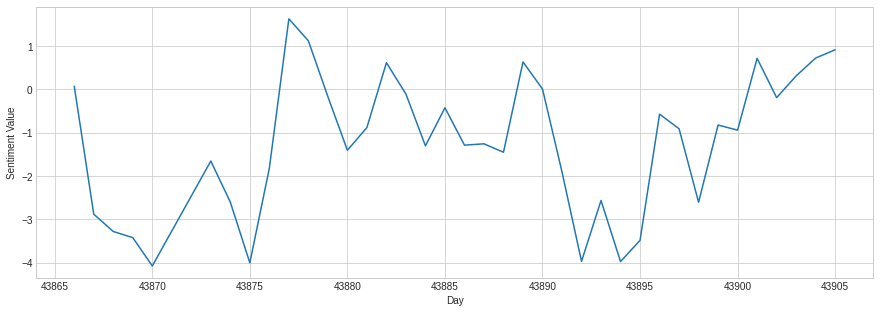

In [ ]:
plt.figure(figsize=(15,5))
plt.style.use('seaborn-whitegrid')
plt.plot(C)
plt.xlabel('Day')
plt.ylabel('Sentiment Value')

Text(0, 0.5, 'Sentiment Value')

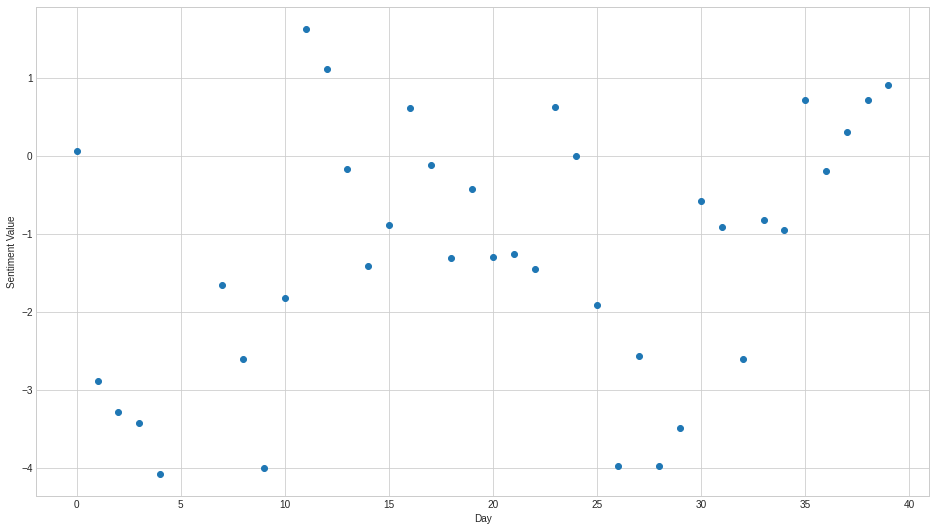

In [ ]:
import numpy as np; np.random.seed(13)
plt.figure(figsize=(16,9))
plt.style.use('seaborn-whitegrid')
plt.plot(C,'o')
plt.xlabel('Day')
plt.ylabel('Sentiment Value')

In [ ]:
d = [x for x in d]
print(d)

[]


Text(0, 0.5, 'Sentiment Value')

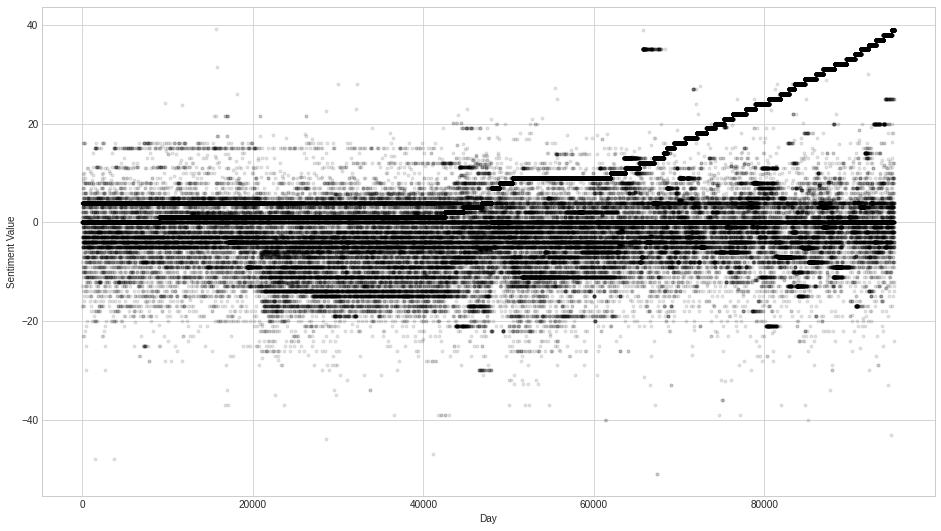

In [ ]:
plt.figure(figsize=(16,9))
plt.style.use('seaborn-whitegrid')
plt.plot(DF,'.',c='k',alpha=0.1)
plt.xlabel('Day')
plt.ylabel('Sentiment Value')

# Word Cloud

TO DO
1. Buat kamus kata-kata penghubung, kasih nama *stopword*
2. Cek untuk tiap kata dalam tweet di z1/2/3, kalau kata tsb enggak ada di kamus *stopword*, hitung frekuensinya, dibikin jadi tipe data *dictionary* aja

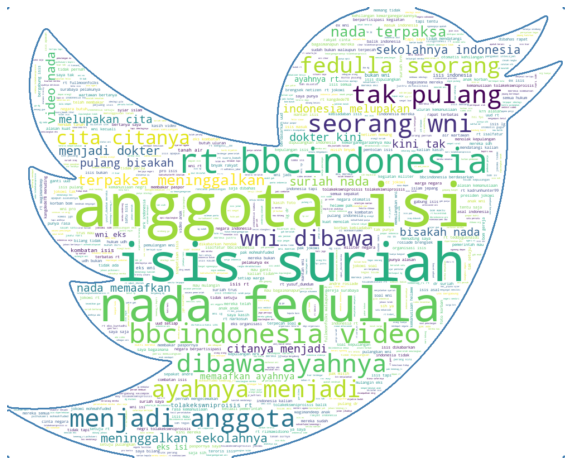

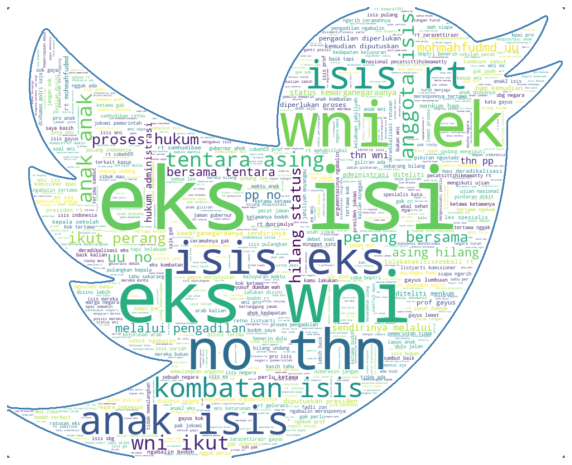

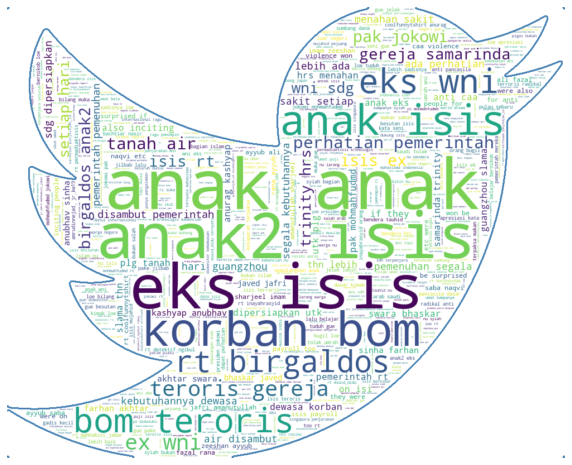

In [ ]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
from wordcloud import WordCloud, STOPWORDS

# Read the whole text.
joinedz1 = '\n'.join(','.join(map(str, row)) for row in z1)
joinedz2 = '\n'.join(','.join(map(str, row)) for row in z2)
joinedz3 = '\n'.join(','.join(map(str, row)) for row in z3)


# mask
awan_mask = np.array(Image.open(requests.get('https://raw.githubusercontent.com/rasbt/datacollect/master/dataviz/twitter_cloud/twitter_mask.png', stream=True).raw))

# using stopword
stopwords = set(STOPWORDS)
wc1 = WordCloud(background_color="white", max_words=10000, stopwords=stopword1, mask=awan_mask,
                contour_width=3, contour_color='steelblue', width=1600, height=800,)
wc2 = WordCloud(background_color="white", max_words=10000, stopwords=stopword1, mask=awan_mask,
                contour_width=3, contour_color='steelblue', width=1600, height=800,)
wc3 = WordCloud(background_color="white", max_words=10000, stopwords=stopword1, mask=awan_mask,
                contour_width=3, contour_color='steelblue', width=1600, height=800,)

# generate word cloud
wc1.generate(joinedz1)
wc2.generate(joinedz2)
wc3.generate(joinedz3)

# show
plt.figure(figsize=(10,10))
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(10,10))
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(10,10))
plt.imshow(wc3, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#menghitung jumlah frekuensi kata yang muncul 
wfreq1 = {}
wfreq2 = {}
wfreq3 = {}
for tweet in z1:
    for word in tweet:
        if word not in wfreq1:
            wfreq1[word] = 0
        wfreq1[word] += 1
for tweet in z2:
    for word in tweet:
        if word not in wfreq2:
            wfreq2[word] = 0
        wfreq2[word] += 1
for tweet in z3:
    for word in tweet:
        if word not in wfreq3:
            wfreq3[word] = 0
        wfreq3[word] += 1

wfreqs1 = {k: v for k, v in sorted(wfreq1.items(), key=lambda x: x[1], reverse=True)}
wfreqs2 = {k: v for k, v in sorted(wfreq2.items(), key=lambda x: x[1], reverse=True)}
wfreqs3 = {k: v for k, v in sorted(wfreq3.items(), key=lambda x: x[1], reverse=True)}
print(wfreqs1)
print(wfreqs2)
print(wfreqs3)

{'@': 77919, 'isis': 53825, 'rt': 39526, 'nada': 33629, 'wni': 32091, '?': 28110, 'indonesia': 26391, 'ke': 25762, 'di': 25648, 'menjadi': 23727, 'ayahnya': 22205, 'dan': 22091, 'yang': 21476, 'mereka': 20233, 'yg': 19523, 'suriah': 15807, '#': 15622, 'pulang': 15283, 'bisa': 14346, 'tak': 14221, 'bbcindonesia': 13873, 'video': 13728, 'eks': 13646, '!': 13409, 'dia': 12973, 'anggota': 12755, 'kini': 11790, 'meninggalkan': 11729, 'seorang': 11718, 'dibawa': 11531, 'dokter': 11386, 'fedulla': 11319, 'memaafkan': 11221, 'bisakah': 11170, 'terpaksa': 11129, 'melupakan': 11068, 'sekolahnya': 11061, 'cita-citanya': 11061, 'ini': 10937, 'tolakekswniproisis': 9914, 'saya': 9519, 'jokowi': 9422, 'tidak': 8353, 'negara': 8093, 'akan': 7724, 'itu': 6938, 'mau': 6652, 'bukan': 5844, 'ada': 5574, 'saja': 5311, 'dengan': 5096, 'kita': 4973, 'sudah': 4842, 'pak': 4789, 'dgn': 4784, 'tapi': 4738, 'masih': 4666, 'teroris': 4440, 'kalau': 4436, 'kombatan': 4138, 'kemanusiaan': 4127, 'pemerintah': 3903, 

# Emoticon Cloud

In [ ]:
!pip install multidict

In [ ]:
emot_counter = {}
for tweet in z1:
    for word in tweet:
        if word in emot:
            val = emot_counter.get(word, 0)
            emot_counter[word] = val + 1
for tweet in z2:
    for word in tweet:
        if word in emot:
            val = emot_counter.get(word, 0)
            emot_counter[word] = val + 1
for tweet in z3:
    for word in tweet:
        if word in emot:
            val = emot_counter.get(word, 0)
            emot_counter[word] = val + 1

In [ ]:
c=0
for tweet in z3:
    for word in tweet:
        if word == '✅':
            print(' '.join(tweet))
            c+=1
print(c)            

In [ ]:
sorted(emot_counter, key=emot_counter.get, reverse=True)

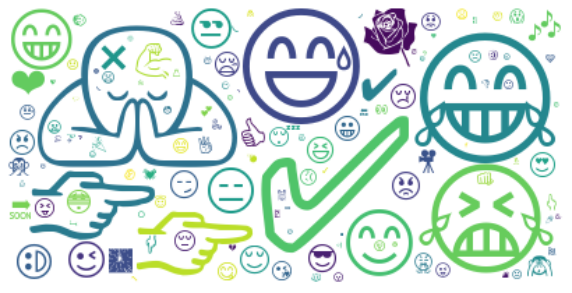

In [ ]:
#import multidict as multidict

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def makeImage(text):
    wc = WordCloud(font_path="Symbola.ttf", background_color="white", max_words=1000)
    # generate word cloud
    wc.generate_from_frequencies(text)
    # show
    plt.figure(figsize=(10,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

makeImage(emot_counter)

# Graf Twitter User Connection

In [ ]:
import networkx as nx
from operator import itemgetter
import matplotlib.pyplot as plt

In [ ]:
def edgeList(df,tokenized_tweet):
    user1 = df["Screen Name"].tolist()
    Mentioned = []
    Tweeted = []
    for i in range(0,len(user1)):
        for j in range(0,len(tokenized_tweet[i])-1):
            if tokenized_tweet[i][j] == '@':
                Tweeted.append(user1[i])
                Mentioned.append('@'+tokenized_tweet[i][j+1])
    edge_list = pd.DataFrame({'from':Tweeted,'to':Mentioned})
    return edge_list
def graph(edge_list):
    G = nx.from_pandas_edgelist(edge_list,'from','to',create_using=nx.MultiDiGraph())
    return G

In [ ]:
edge1 = edgeList(data1,z1)
edge2 = edgeList(data2,z2)
edge3 = edgeList(data3,z3)
print('banyaknya sisi unik tiap data:',len(edge1),len(edge2),len(edge3))
join_edge = pd.concat([edge1,edge2,edge3], ignore_index=True)
print(join_edge)

banyaknya sisi unik tiap data: 77917 42615 44213
                  from              to
0              @ienuli  @aryprasetyo85
1              @ienuli    @infosebelah
2              @ienuli     @namaku_mei
3              @ienuli      @ensyclo47
4              @ienuli      @cintada17
...                ...             ...
164740    @wahyuutomos     @samhudibae
164741     @aizahputri      @aliralira
164742     @Dannyagiza      @kompascom
164743    @hhhhh_hajar      @lanhudiee
164744  @ImanHidayat85      @kompascom

[164745 rows x 2 columns]


In [ ]:
#G1 = graph(edge1)
#G2 = graph(edge2)
#G3 = graph(edge3)
G = graph(join_edge)
G_df = nx.to_pandas_edgelist(G)

In [ ]:
G_sub = G

In [ ]:
#menghilangkan node dengan derajat kurang dari 1000
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1000]
for x in to_be_removed:
    G_sub.remove_node(x)

In [ ]:
Gs_df = nx.to_pandas_edgelist(G_sub)
print(G_df,Gs_df)

                source          target
0              @ienuli  @aryprasetyo85
1              @ienuli    @infosebelah
2              @ienuli     @namaku_mei
3              @ienuli      @ensyclo47
4              @ienuli      @cintada17
...                ...             ...
164740  @Rod_Cacerolas      @yricovery
164741  @Rod_Cacerolas  @micela_santos
164742  @Rod_Cacerolas     @dw_espanol
164743     @Dannyagiza      @kompascom
164744    @hhhhh_hajar      @lanhudiee

[164745 rows x 2 columns]                source         target
0    @wahhabicc_jabar   @wagimandeep
1    @wahhabicc_jabar   @wagimandeep
2    @wahhabicc_jabar   @wagimandeep
3    @wahhabicc_jabar  @rizmawidiono
4    @wahhabicc_jabar  @rizmawidiono
..                ...            ...
311       @samhudibae  @yusuf_dumdum
312       @samhudibae    @samhudibae
313       @samhudibae    @samhudibae
314       @samhudibae    @samhudibae
315       @samhudibae    @samhudibae

[316 rows x 2 columns]


In [ ]:
print('banyaknya user unik untuk semua data:',len(G.nodes))

banyaknya user unik untuk semua data: 54945


In [ ]:
#yang ini untuk membuat aturan biar grafnya warna-warni berdasarkan derajatnya --tidak dipakai
degree = [x[1] for x in list(G.degree())]
degree_ = [x*100 for x in degree]
inDegree = [x[1]*100 for x in list(G.in_degree())]
outDegree = [x[1]*100 for x in list(G.out_degree())]

In [ ]:
node_and_degree = G.degree()
sortedDegree = sorted(node_and_degree, key=itemgetter(1), reverse=True)
sortedDegree[0:20]

[('@bbcindonesia', 14119),
 ('@jokowi', 11896),
 ('@mohmahfudmd', 7564),
 ('@kemenag_ri', 3148),
 ('@detikcom', 2264),
 ('@ISIS_Balik_NO', 1940),
 ('@wahhabicc_jabar', 1915),
 ('@wagimandeep', 1655),
 ('@yusuf_dumdum', 1499),
 ('@narkosun', 1438),
 ('@divhumas_polri', 1334),
 ('@jr_kw19', 1308),
 ('@kangdede78', 1244),
 ('@rizmawidiono', 1241),
 ('@birgaldos', 1233),
 ('@bnptri', 1199),
 ('@samhudibae', 1173),
 ('@isalfatur', 1129),
 ('@polhukamri', 1102),
 ('@p3nj3l4j4h_id', 951)]

In [ ]:
#banyaknya node pada graf G_sub
len(G_sub.nodes())

19

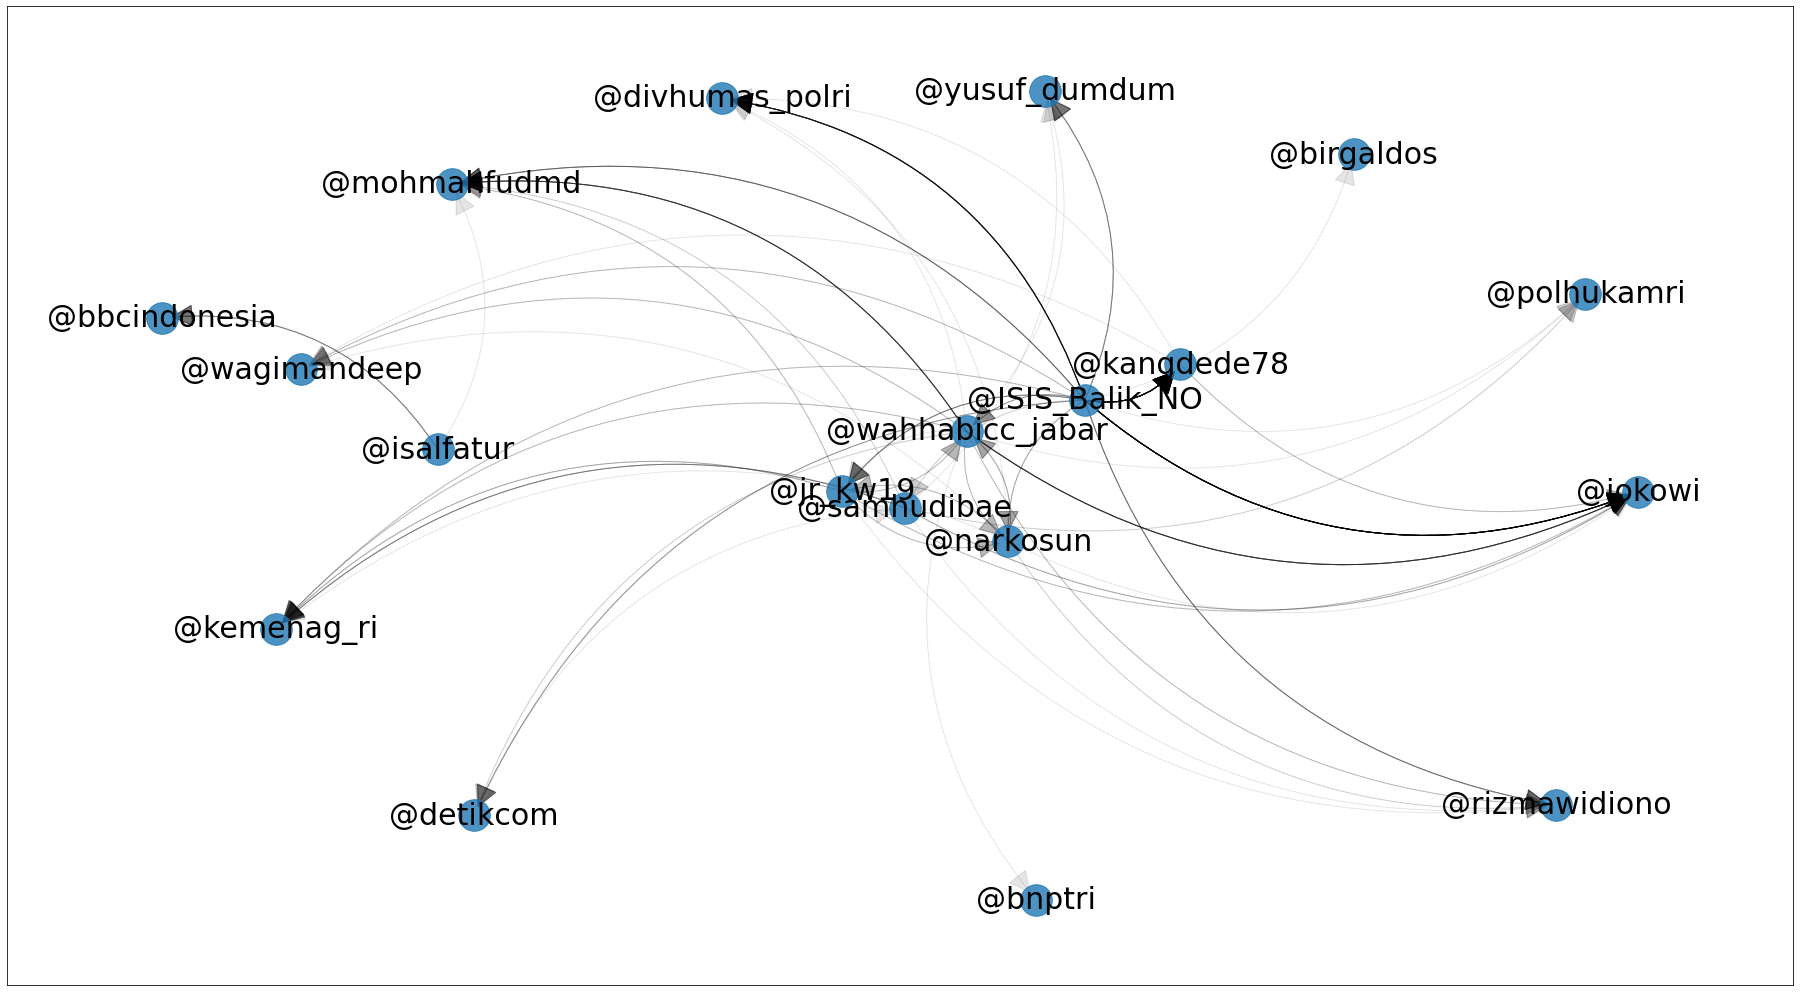

In [ ]:
# Plot it
plt.figure(figsize=(32,18))
plt.rcParams['axes.facecolor'] = 'white'
pos = nx.spring_layout(G_sub,k=1)
nx.draw_networkx_nodes(G_sub, pos, alpha=0.8, node_size=1000) #, node_size=degree_, node_color=degree_,
nx.draw_networkx_edges(G_sub, pos, style='dashed', alpha=0.1, connectionstyle='arc3,rad=0.3',arrowstyle='-|>',arrowsize=50,edge_color='k')
nx.draw_networkx_labels(G_sub, pos, font_color='k',font_size=30)
plt.show()

# Cek Sentimen User

Bagian sini (kembali) mengurusi sentimen

In [ ]:
a = [x[0] for x in sortedDegree[0:10]]
def avSen(df,z,User):
    idx = []
    user = df["Screen Name"].tolist()
    for i in range(0,len(z)):
            if user[i] == User:
                idx.append(i)
    sen = polarityValue(z,idx)
    sen_av = 0
    if len(sen[0]) != 0:
        sen_av = sum(sen[0])/len(sen[0])
    return sen_av
def avSenAll(user):
    s = round((avSen(data1,z1,user)+avSen(data2,z2,user)+avSen(data3,z3,user))/3,2)
    return s

In [ ]:
l = ['@wahhabicc_jabar', '@samhudibae', '@narkosun','@jr_kw19']
for user in l:
    print(avSenAll(user))

-1.01
-2.34
-3.99
-4.48


In [ ]:
a = ['@bbcindonesia', '@jokowi', '@mohmahfudmd', '@kemenag_ri', '@detikcom', '@wagimandeep', '@divhumas_polri']
for user in a:
    print(avSenAll(user))

0.0
-1.67
-3.67
0.0
0.0
0.0
0.0


In [ ]:
b = ['@ISIS_Balik_NO','@JohnIrwan4','@CANDAdanBISNIS','@AnakKolong___','@becak125cc','@enny_endah','@ephraym8','@yudhapati88','@AmstrongBiring','@salahsambungya']
for user in b:
    print(avSenAll(user))


-1.54
-3.39
-2.51
-2.88
-4.77
-1.02
-1.74
-1.76
-4.24
-1.71
